In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
import random
from scipy.stats import skew
from scipy.stats import kurtosis
import csv
import datetime
import pandas

In [2]:
import data_corruption

In [3]:
def read_data(file_path):
  # Add new data to CSV file
    std = []
    var = []
    dict_metrics = {}
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file, delimiter=',')
        line_count = 0
        for row in reader:
            if line_count == 0:
                head = (row[0].strip('][').split(', '))[2:]
                aux = (row[1].strip('][').split(', '))
                for i in range(0,len(head),2):
                    dict_metrics[str(head[i][6:-1])] = {'mean':[],'std':[]}
            else:
                aux = (row[0].strip('][').split(', '))
            aux2 = [float(i) for i in aux]
            std.append(aux2[0])
            var.append(aux2[1])
            for i in range(0,len(head),2):
                dict_metrics[str(head[i][6:-1])]['mean'].append(aux2[i+2])
                dict_metrics[str(head[i][6:-1])]['std'].append(aux2[i+3])
            line_count += 1
            
    return std,var,dict_metrics

In [4]:
def spect_noise_estimation(spect, qntty, ppm):
  std_array = np.empty(qntty)

  for i in range(qntty):
    idx_noise_1 = np.abs(ppm[i,:] - 8.5).argmin()
    idx_noise_2 = np.abs(ppm[i,:] - 9.5).argmin()
    idx_noise_3 = np.abs(ppm[i,:] - 10.5).argmin()

    #assumes ppm is inverted: smaller values in higher indexes
    ppm_array_1 = ppm[i,idx_noise_2:idx_noise_1]
    ppm_array_2 = ppm[i,idx_noise_3:idx_noise_2]
    spect_array_1 = np.real(spect[i,idx_noise_2:idx_noise_1])
    spect_array_2 = np.real(spect[i,idx_noise_3:idx_noise_2])

    estimate_1 = np.polyfit(ppm_array_1, spect_array_1, 2)
    estimate_2 = np.polyfit(ppm_array_2, spect_array_2, 2)
    aux_1 = (estimate_1[0]*(ppm_array_1**2)) + (estimate_1[1]*ppm_array_1) +  estimate_1[2]
    aux_2 = (estimate_2[0]*(ppm_array_2**2)) + (estimate_2[1]*ppm_array_2) +  estimate_2[2]
    detrending_1 = spect_array_1 - aux_1
    detrending_2 = spect_array_2 - aux_2
    std_1 = np.std(detrending_1)
    std_2 = np.std(detrending_2)

    if np.abs(std_1) < np.abs(std_2):
      std = std_1
    else:
      std = std_2

    std_array[i] = std

  return std_array

def spect_SNR_estimation(spect, qntty, ppm, ppm_min_peak,ppm_max_peak):

  noise_array = spect_noise_estimation(spect, qntty, ppm)
  SNR_array = np.empty(qntty)
  peak_array = np.empty(qntty)

  for i in range(qntty):
    idx_GABA_0 = np.abs(ppm[i,:] - ppm_min_peak).argmin()
    idx_GABA_1 = np.abs(ppm[i,:] - ppm_max_peak).argmin()
    peak_amplitude = np.max(np.abs(np.real(spect[i,idx_GABA_1:idx_GABA_0])))

    SNR = peak_amplitude/(2*noise_array[i])
    SNR_array[i] = SNR
    peak_array[i] = peak_amplitude

  return SNR_array, noise_array, peak_array

In [5]:
def normalize_vector_between_minus_one_and_one(complex_array):
    real_parts = complex_array.real
    imaginary_parts = complex_array.imag

    min_real = np.min(real_parts)
    max_real = np.max(real_parts)
    min_imaginary = np.min(imaginary_parts)
    max_imaginary = np.max(imaginary_parts)

    range_real = max_real - min_real
    range_imaginary = max_imaginary - min_imaginary

    normalized_real = (((real_parts - min_real)/range_real)*2)-1
    normalized_imaginary = (((imaginary_parts - min_imaginary)/range_imaginary)*2)-1

    normalized_complex_array = normalized_real + 1j*normalized_imaginary
    return normalized_complex_array

def get_normalized_spectrogram(fids,bandwidth,qntty,a,b,norm_abs,correct_time):
    w = hann(256, sym=True)
    mfft_ = 446
    SFT = ShortTimeFFT(w, hop=10, fs=bandwidth, mfft=mfft_, scale_to='magnitude', fft_mode = 'centered')
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i,:])
        if norm_abs == True:
            spgram.append(aux/np.max(np.abs(aux)))
        else:
            spgram.append(normalize_vector_between_minus_one_and_one(aux))
    spgram = np.array(spgram)
    
    freq_spect = np.flip(np.linspace(f_lo,f_hi,mfft_))
    ppm_spect = a*freq_spect+b
    t_spect = np.linspace(t_lo,t_hi,spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:,:,zero_idx:one_idx]
    
    return spgram, freq_spect, ppm_spect, t_spect

In [6]:
def center_bins(bins):
    mean_bins = []
    for i in range(bins.shape[0]):
        mean_bins.append([])
        for j in range(bins.shape[1]-1):
            aux = (bins[i,j+1]+bins[i,j])/2
            mean_bins[i].append(aux)
    mean_bins = np.array(mean_bins)
    return mean_bins

In [7]:
def get_histogram(spgram,qntty):
    
    hist = []
    bins_hist = []
    for i in range(qntty):
        #switched from 200 to 8000, from density to absolute
        aux, bins = np.histogram(np.real(spgram[i,:,:]), 8000)
        #added this normalization
        aux = aux/aux.sum()
        hist.append(aux)
        bins_hist.append(bins)
    hist = np.array(hist)
    bins_hist = np.array(bins_hist)

    bins_ = center_bins(bins_hist)
    return hist, bins_

In [8]:
def calculate_TVs(spgram):
  aux_delta_l = np.empty(spgram.shape)
  for i in range(spgram.shape[1]-1):
    aux = np.real(spgram[:,i+1,:]-spgram[:,i,:])
    aux_delta_l[:,i,:]=aux
  aux_delta_l[:,-1,:] = np.zeros((spgram.shape[0],spgram.shape[2]))
  aux_delta_c = np.empty(spgram.shape)
  for i in range(spgram.shape[2]-1):
    aux = np.real(spgram[:,:,i+1]-spgram[:,:,i])
    aux_delta_c[:,:,i]=aux
  aux_delta_c[:,:,-1] = np.zeros((spgram.shape[0],spgram.shape[1]))
  TV_aniso = np.sum(np.abs(aux_delta_l)+np.abs(aux_delta_c), axis =(1,2))
  TV_iso = np.sum(np.sqrt((np.abs(aux_delta_l)**2)+(np.abs(aux_delta_c)**2)), axis=(1,2))

  return TV_aniso, TV_iso

In [9]:
def stats(seq_stats,names):

  metrics = {}
  for i,value in enumerate(seq_stats):
    metrics[names[i]] = {}
    metrics[names[i]]['mean'] = np.mean(value)
    metrics[names[i]]['std'] = np.std(value)

  return metrics

In [10]:
def get_histogram_metrics(hist,bins):
    #no median, no range, no cov, new skew (corrected), new kurt (corrected), added max, added LWHM
    argmax_hist = np.argmax(hist,axis=1)
    mode_ = []
    for i in range(argmax_hist.shape[0]):
        mode_.append(bins[i,argmax_hist[i]]) #pixel value that happens the most
    mode_ = np.array(mode_)
    max_ = np.max(hist,axis=1) #peak amplitude

    LWHM_ = []
    value_ref_larg = 1e-4
    for i in range(hist.shape[0]):
        aux_ans_min = 10000000
        aux_idx_min = 0
        aux_ans_max= 10000000
        aux_idx_max = 0
        for j in range(argmax_hist[i]):
            if np.abs(hist[i,j] - value_ref_larg) < aux_ans_min:
                aux_ans_min = np.abs(hist[i,j] - value_ref_larg)
                aux_idx_min = j
        for j in range(argmax_hist[i],hist.shape[1]):
            if np.abs(hist[i,j] - value_ref_larg) < aux_ans_max:
                aux_ans_max = np.abs(hist[i,j] - value_ref_larg)
                aux_idx_max = j
        LWHM_.append(np.abs(bins[i,aux_idx_max]-bins[i,aux_idx_min]))
    LWHM_ = np.array(LWHM_) #linewidth

    
    mean_ = np.sum(bins*hist,axis=1)
    std_ = np.sqrt(np.sum(((bins - mean_[:, np.newaxis])**2)*hist,axis=1))
    skewness_ = np.sum(((bins - mean_[:, np.newaxis])/std_[:, np.newaxis])**3*hist,axis=1)
    kurtosis_ = np.sum(((bins - mean_[:, np.newaxis])/std_[:, np.newaxis])**4*hist,axis=1)
    
    names = ['mode','max','width','skewness','kurtosis']
    seq_stats = (mode_,max_,LWHM_,skewness_,kurtosis_)
    metrics = stats(seq_stats,names)

    return metrics

In [11]:
def get_spgram_metrics(spgram,time,ppm):
  mean_ = np.mean(np.real(spgram),axis = (1,2))
  median_ = np.median(np.real(spgram),axis = (1,2))
  std_ = np.std(np.real(spgram),axis = (1,2))
  trace_ = []
  for i in range(spgram.shape[0]):
    trace_.append(np.trace(np.cov(np.real(spgram[i,:,:]))))
  trace_ = np.array(trace_)
  TV_aniso,TV_iso = calculate_TVs(spgram)

  idx_time_1 = np.abs(time - 0.4).argmin()
  idx_time_2 = np.abs(time - 0.6).argmin()
  idx_freq_1 = np.abs(np.flip(ppm) - 1).argmin()
  idx_freq_2 = np.abs(np.flip(ppm) - 8).argmin()
  sum_late = np.sum(np.abs(np.real(spgram[:,:,idx_time_2:])),axis=(1,2))
  #changed mean late and std late || before np.mean(np.abs(np.real(
  mean_late = np.mean(np.real(spgram[:,:,idx_time_2:]),axis=(1,2))
  std_late = np.std(np.real(spgram[:,:,idx_time_2:]),axis=(1,2))
  TV_aniso_late,TV_iso_late = calculate_TVs(spgram[:,idx_freq_1:idx_freq_2,idx_time_2:])
  #changed mean main and std main || before np.mean(np.abs(np.real(
  mean_main_sig = np.mean(np.real(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1]),axis=(1,2))
  std_main_sig = np.std(np.real(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1]),axis=(1,2))
  TV_aniso_main_sig,TV_iso_main_sig = calculate_TVs(spgram[:,idx_freq_1:idx_freq_2,:idx_time_1])

  names = ['MEAN_total','median_total','STD_total','trace_total','TV_aniso_total','TV_iso_total',
           'sum_late','MEAN_late','STD_late','TV_aniso_late','TV_iso_late',
           'MEAN_main_sig','STD_main_sig','TV_aniso_main_sig','TV_iso_main_sig']
  seq_stats = (mean_,median_,std_,trace_,TV_aniso,TV_iso,
               sum_late,mean_late,std_late,TV_aniso_late,TV_iso_late,
               mean_main_sig,std_main_sig,TV_aniso_main_sig,TV_iso_main_sig)
  metrics = stats(seq_stats,names)

  return metrics

In [12]:
path_gt_file = '../sample_data.h5'

In [13]:
qntty = 200

In [14]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File(path_gt_file) as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(200, 2048, 2)
(200, 2048)
(200, 2048)


In [15]:
file_spectrum_path = 'data_Real_Norm_ABS_STFT_FID_spectrum.csv'
file_hist_path = 'data_Real_Norm_ABS_STFT_FID_hist.csv' 
file_spgram_path = 'data_Real_Norm_ABS_STFT_FID_spgram.csv' 

In [16]:
def from_list_to_array(dict_data):
    keys = list(dict_data.keys())
    for key in keys:
        aux1 = np.array(dict_data[key]['mean'])
        aux2 = np.array(dict_data[key]['std'])
        dict_data[key]['mean'] = aux1
        dict_data[key]['std'] = aux2

    return dict_data

In [17]:
std,var, metrics_spectrum_corrupted_avgs = read_data(file_spectrum_path)
std,var, metrics_hist_corrupted_avgs = read_data(file_hist_path)
std,var, metrics_spgram_corrupted_avgs = read_data(file_spgram_path)
metrics_spectrum_corrupted_avgs = from_list_to_array(metrics_spectrum_corrupted_avgs)
metrics_hist_corrupted_avgs = from_list_to_array(metrics_hist_corrupted_avgs)
metrics_spgram_corrupted_avgs = from_list_to_array(metrics_spgram_corrupted_avgs)
std = np.array(std)
var = np.array(var)

In [18]:
#general
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]

names_stats_spectrum = ['SNR','STD','peak']
names_stats_hist = ['mode','max','width','skewness','kurtosis']
names_stats_spgram = ['MEAN_total','median_total','STD_total','trace_total','TV_aniso_total','TV_iso_total',
           'sum_late','MEAN_late','STD_late','TV_aniso_late','TV_iso_late',
           'MEAN_main_sig','STD_main_sig','TV_aniso_main_sig','TV_iso_main_sig']

SNR_gt, std_gt, peak_gt = spect_SNR_estimation(spectra_gt_diff, qntty, ppm, 2.79, 3.55)
metrics_spectrum_gt = stats((SNR_gt, std_gt, peak_gt),names_stats_spectrum)

gt_fids_diff = gt_fids[:,:,1]-gt_fids[:,:,0]
spgram_gt, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids_diff,bandwidth,qntty,a,b,True,False)
metrics_spgram_gt = get_spgram_metrics(spgram_gt,t_spect,ppm_spect)

hist_gt, bins_hist = get_histogram(spgram_gt,qntty)
metrics_hist_gt = get_histogram_metrics(hist_gt,bins_hist)

In [19]:
test_idx = np.arange(std.shape[0])

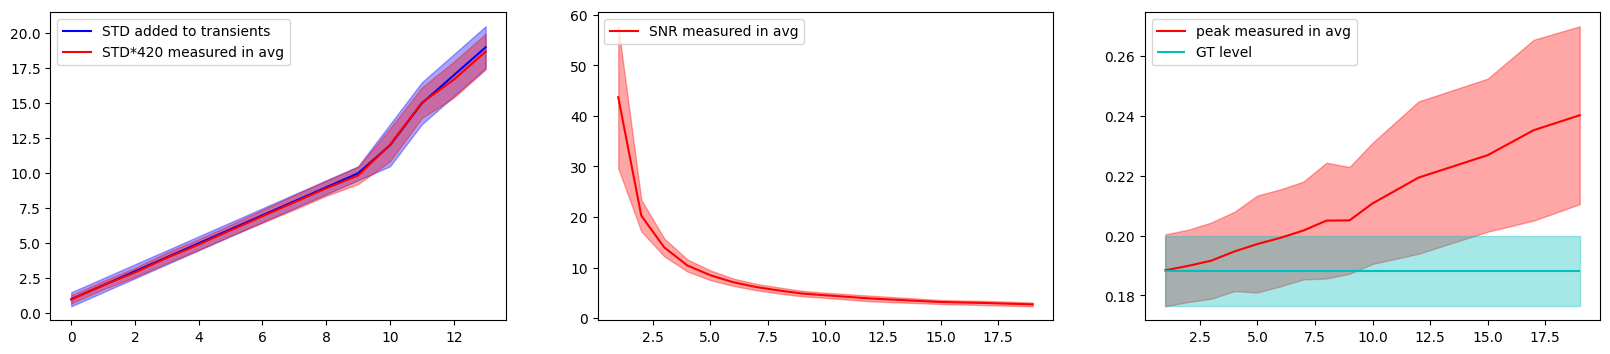

In [20]:
fig, ax = plt.subplots(1,3,figsize=(20,4))

ax[0].plot(std,color='blue', label = 'STD added to transients')
ax[0].fill_between(test_idx, std - var, std + var, alpha=0.35, color = 'blue')
ax[0].plot(metrics_spectrum_corrupted_avgs['STD']['mean']*420,color='red', label = 'STD*420 measured in avg')
ax[0].fill_between(test_idx, metrics_spectrum_corrupted_avgs['STD']['mean']*420 - metrics_spectrum_corrupted_avgs['STD']['std']*420, 
                   metrics_spectrum_corrupted_avgs['STD']['mean']*420 + metrics_spectrum_corrupted_avgs['STD']['std']*420, alpha=0.35, color = 'red')
ax[0].legend(loc='upper left')

ax[1].plot(std,metrics_spectrum_corrupted_avgs['SNR']['mean'],color='red', label = 'SNR measured in avg')
ax[1].fill_between(std, metrics_spectrum_corrupted_avgs['SNR']['mean'] - metrics_spectrum_corrupted_avgs['SNR']['std'], 
                   metrics_spectrum_corrupted_avgs['SNR']['mean'] + metrics_spectrum_corrupted_avgs['SNR']['std'], alpha=0.35, color = 'red')
ax[1].legend(loc='upper left')


ax[2].plot(std,metrics_spectrum_corrupted_avgs['peak']['mean'],color='red', label = 'peak measured in avg')
ax[2].fill_between(std, metrics_spectrum_corrupted_avgs['peak']['mean'] - metrics_spectrum_corrupted_avgs['peak']['std'], 
                   metrics_spectrum_corrupted_avgs['peak']['mean'] + metrics_spectrum_corrupted_avgs['peak']['std'], alpha=0.35, color = 'red')
ax[2].hlines(metrics_spectrum_gt['peak']['mean'],std[0],std[-1],color='c',label='GT level')
ax[2].fill_between(std, metrics_spectrum_gt['peak']['mean'] - metrics_spectrum_gt['peak']['std'], 
                   metrics_spectrum_gt['peak']['mean'] + metrics_spectrum_gt['peak']['std'], alpha=0.35, color = 'c')
ax[2].legend(loc='upper left')
#plt.savefig('noise_progresion')

In [21]:
print(metrics_spectrum_gt)

{'SNR': {'mean': 97129.94195541808, 'std': 9152.749125123119}, 'STD': {'mean': 9.73085127528734e-07, 'std': 5.7079493532556176e-08}, 'peak': {'mean': 0.188230026087735, 'std': 0.011597957288998284}}


(0.0, 1.0, 0.0, 1.0)

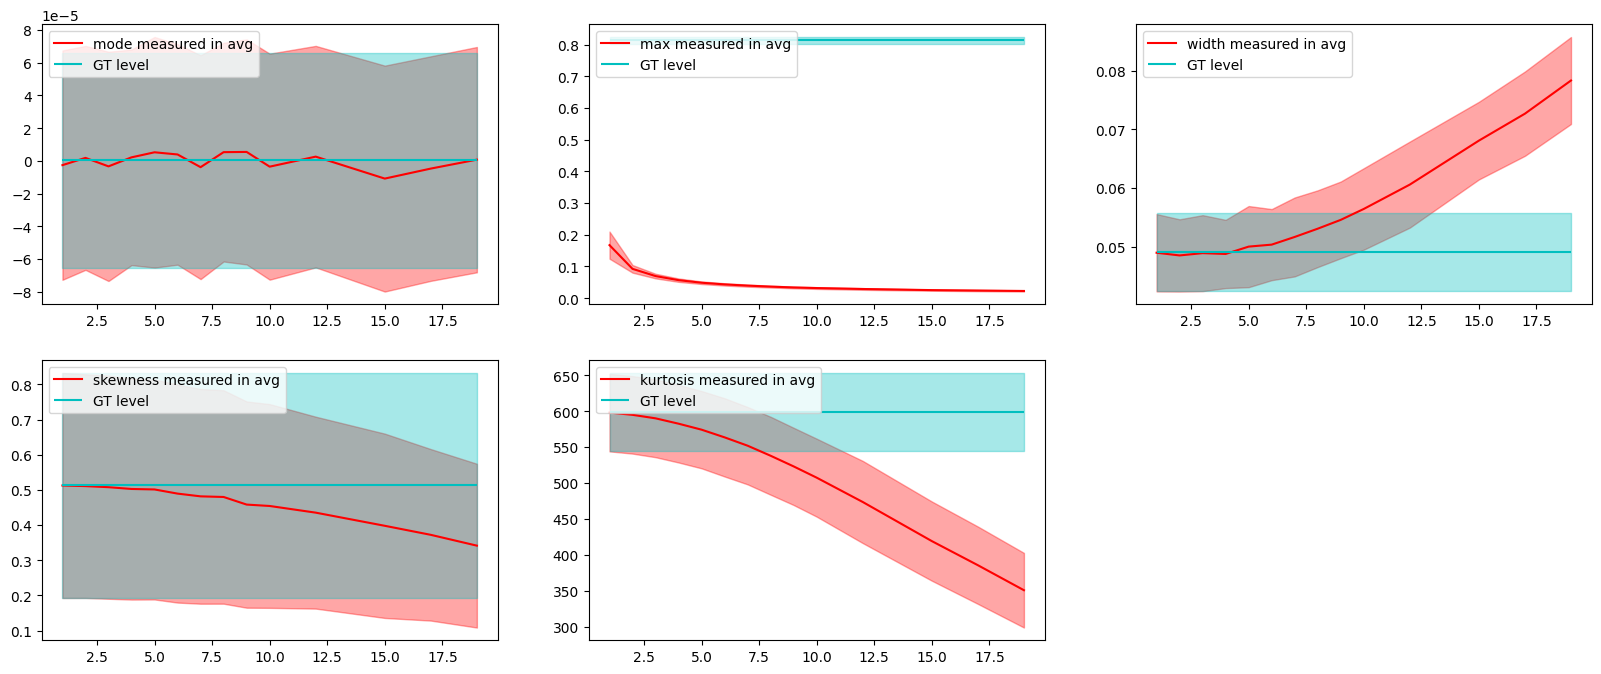

In [22]:
fig, ax = plt.subplots(2,3,figsize=(20,8))

for i in range(len(names_stats_hist)):
    ax.flat[i].plot(std,metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'],color='red', label = names_stats_hist[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'] - metrics_hist_corrupted_avgs[names_stats_hist[i]]['std'], 
                       metrics_hist_corrupted_avgs[names_stats_hist[i]]['mean'] + metrics_hist_corrupted_avgs[names_stats_hist[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_hist_gt[names_stats_hist[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_hist_gt[names_stats_hist[i]]['mean'] - metrics_hist_gt[names_stats_hist[i]]['std'], 
                       metrics_hist_gt[names_stats_hist[i]]['mean'] + metrics_hist_gt[names_stats_hist[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

ax[1,2].axis('off')

In [23]:
print(metrics_hist_gt)

{'mode': {'mean': 2.3768437051818746e-07, 'std': 6.58011040293561e-05}, 'max': {'mean': 0.8135970462078377, 'std': 0.010280917178919614}, 'width': {'mean': 0.04901121879588028, 'std': 0.006635275406487825}, 'skewness': {'mean': 0.5131743590731503, 'std': 0.31925619534322053}, 'kurtosis': {'mean': 599.1143076421664, 'std': 53.88569461156801}}


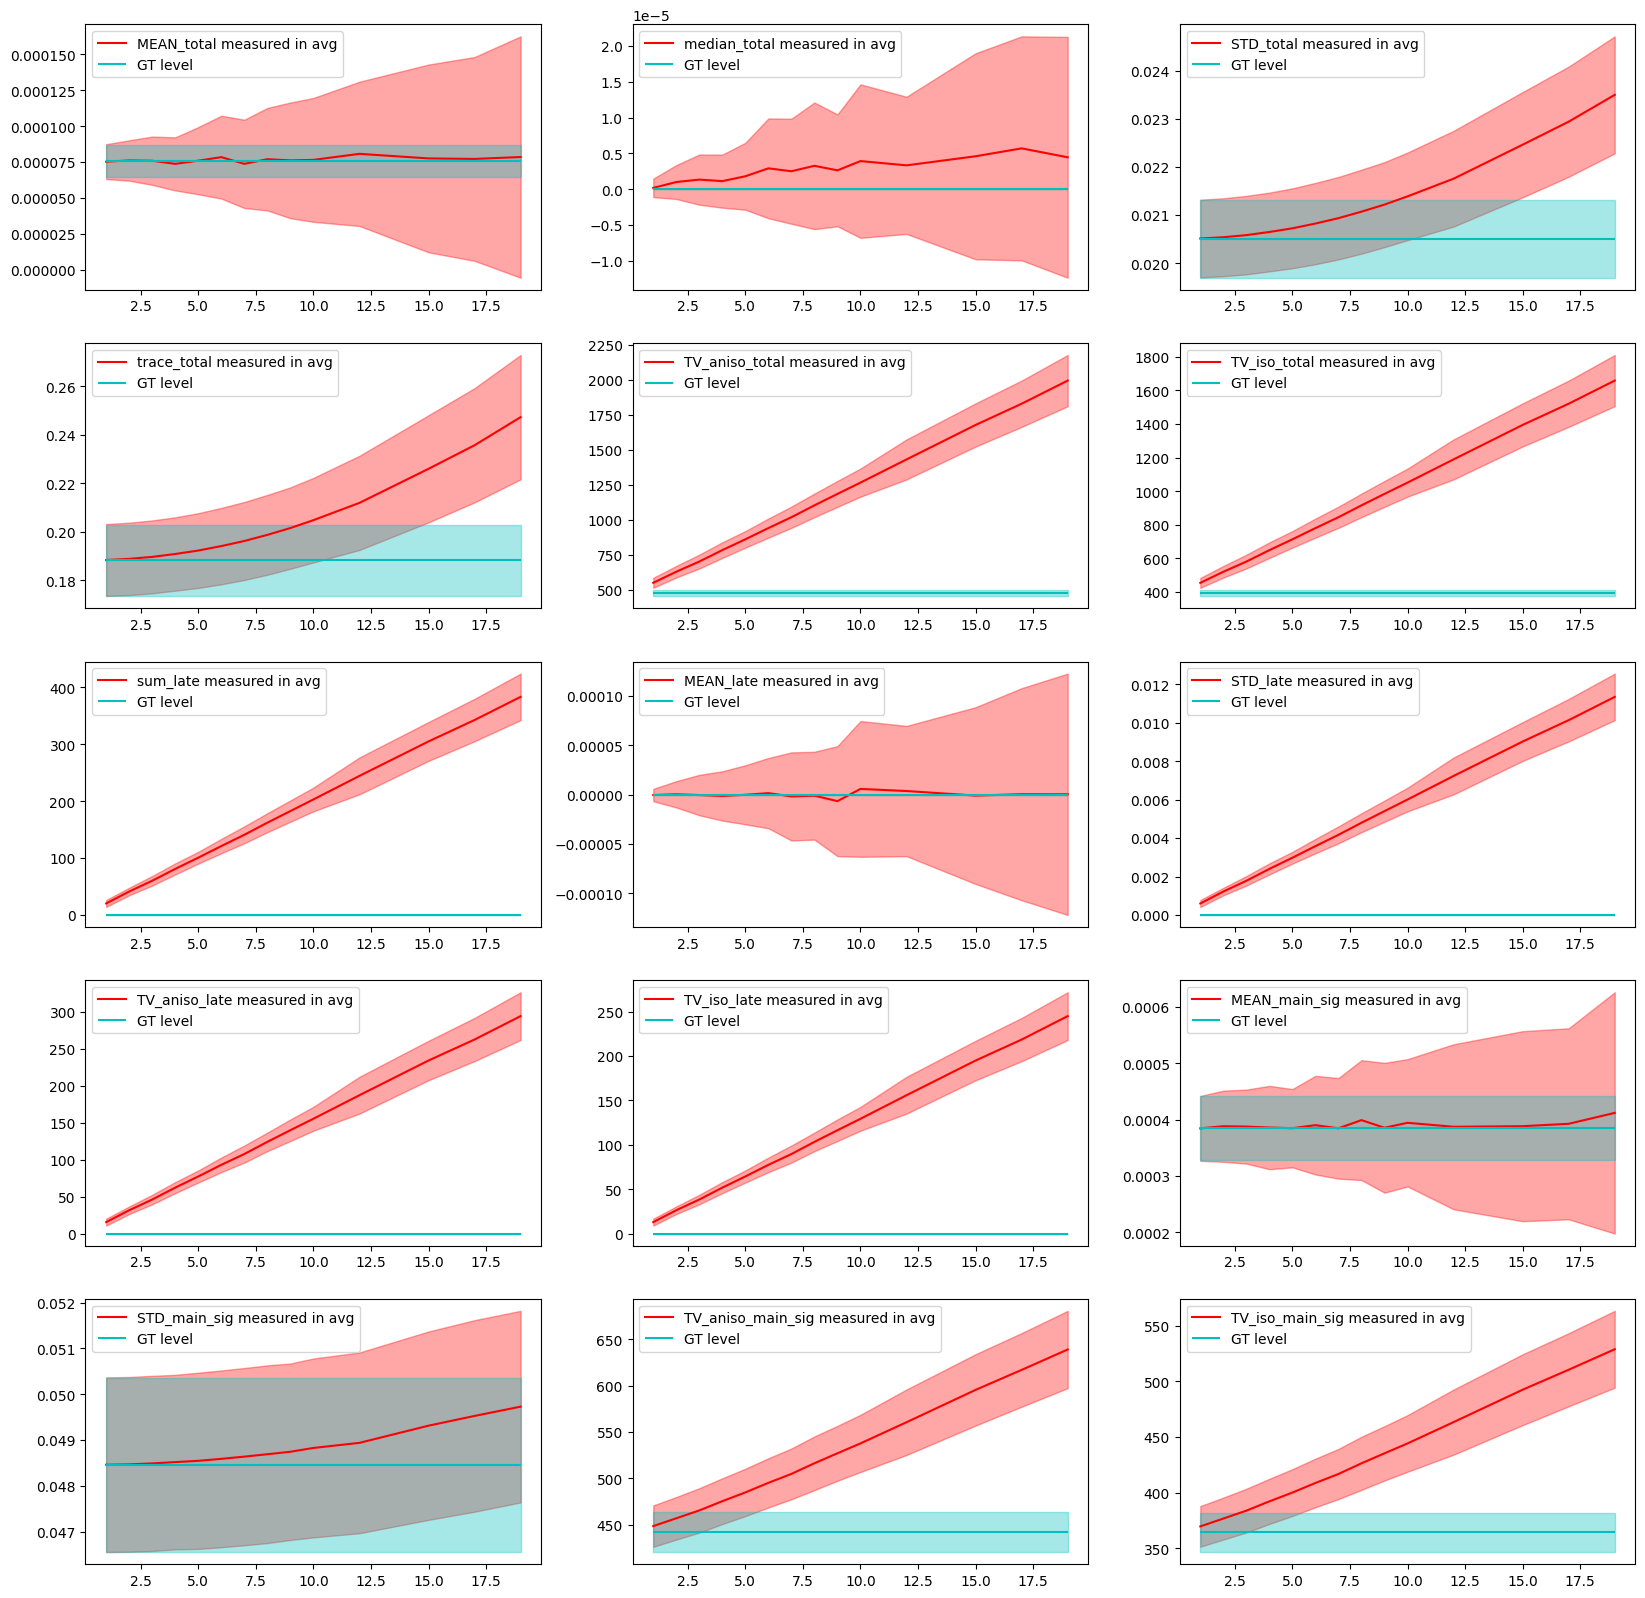

In [24]:
fig, ax = plt.subplots(5,3,figsize=(20,20))

for i in range(len(names_stats_spgram)):
    ax.flat[i].plot(std,metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'],color='red', label = names_stats_spgram[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'] - metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['mean'] + metrics_spgram_corrupted_avgs[names_stats_spgram[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_spgram_gt[names_stats_spgram[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_spgram_gt[names_stats_spgram[i]]['mean'] - metrics_spgram_gt[names_stats_spgram[i]]['std'], 
                       metrics_spgram_gt[names_stats_spgram[i]]['mean'] + metrics_spgram_gt[names_stats_spgram[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

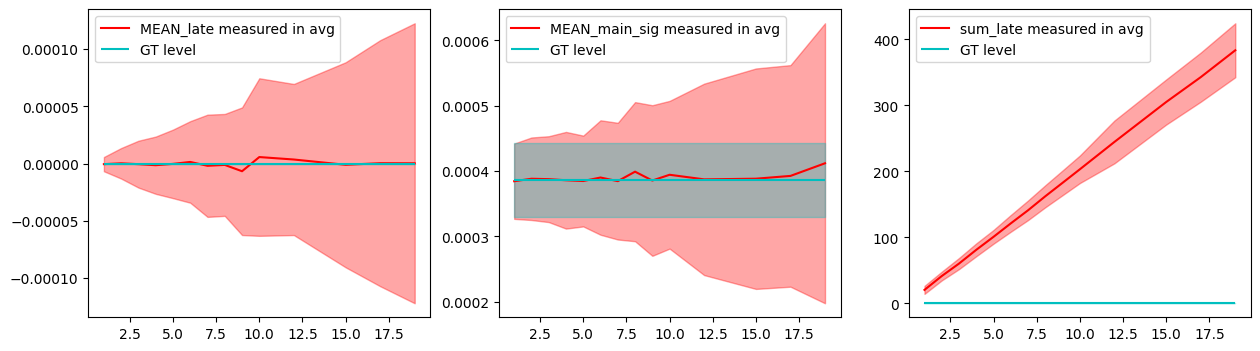

In [68]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

names_aux = ['MEAN_late','MEAN_main_sig','sum_late']

for i in range(len(names_aux)):
    ax.flat[i].plot(std,metrics_spgram_corrupted_avgs[names_aux[i]]['mean'],color='red', label = names_aux[i]+' measured in avg')
    ax.flat[i].fill_between(std, metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] - metrics_spgram_corrupted_avgs[names_aux[i]]['std'], 
                       metrics_spgram_corrupted_avgs[names_aux[i]]['mean'] + metrics_spgram_corrupted_avgs[names_aux[i]]['std'], alpha=0.35, color = 'red')
    ax.flat[i].hlines(metrics_spgram_gt[names_aux[i]]['mean'],std[0],std[-1],color='c',label='GT level')
    ax.flat[i].fill_between(std, metrics_spgram_gt[names_aux[i]]['mean'] - metrics_spgram_gt[names_aux[i]]['std'], 
                       metrics_spgram_gt[names_aux[i]]['mean'] + metrics_spgram_gt[names_aux[i]]['std'], alpha=0.35, color = 'c')
    ax.flat[i].legend(loc='upper left')

In [25]:
print(metrics_spgram_gt)

{'MEAN_total': {'mean': 7.5820086123727e-05, 'std': 1.1345296827052762e-05}, 'median_total': {'mean': -4.452946695288792e-14, 'std': 1.263367045463628e-14}, 'STD_total': {'mean': 0.020502614661596356, 'std': 0.0008045516404794034}, 'trace_total': {'mean': 0.1881420540994715, 'std': 0.014792388372726303}, 'TV_aniso_total': {'mean': 477.3615387453893, 'std': 22.746335627544187}, 'TV_iso_total': {'mean': 393.37001217846756, 'std': 18.639450106470658}, 'sum_late': {'mean': 0.013892491789013785, 'std': 0.0007339453830316911}, 'MEAN_late': {'mean': -1.9634102829271753e-08, 'std': 2.2144323399584357e-09}, 'STD_late': {'mean': 2.9102847535617437e-06, 'std': 1.0775177689607913e-07}, 'TV_aniso_late': {'mean': 0.025665501807971777, 'std': 0.0010834032417766034}, 'TV_iso_late': {'mean': 0.020958673043067727, 'std': 0.0008797647883194453}, 'MEAN_main_sig': {'mean': 0.000385801286866224, 'std': 5.674283061251553e-05}, 'STD_main_sig': {'mean': 0.0484556468474806, 'std': 0.001903729666371233}, 'TV_ani

In [20]:
std,var, metrics_hist_M1P1 = read_data('data_Real_Norm_M1P1_STFT_FID_hist.csv')
metrics_hist_M1P1 = from_list_to_array(metrics_hist_M1P1)
std,var, metrics_spgram_M1P1 = read_data('data_Real_Norm_M1P1_STFT_FID_spgram.csv')
metrics_spgram_M1P1 = from_list_to_array(metrics_spgram_M1P1)
spgram_gt_M1P1, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(gt_fids_diff,bandwidth,qntty,a,b,False,False)
metrics_spgram_gt_M1P1 = get_spgram_metrics(spgram_gt_M1P1,t_spect,ppm_spect)

In [34]:
aux = np.array([-1, -0.4, -0.6, -0.6, -0.5, -0.8, -0.2, 0.1, 0.2,1])
mean_aux = np.mean(aux)
print(mean_aux)
std_aux = np.std(aux)
aux_2 = np.array([-1, -0.4, -0.6, -0.6, -0.5, -0.8])
print(np.sum((aux_2-mean_aux)**3))
aux_3 = np.array([-0.2,0.1, 0.2,1])
print(np.sum((aux_3-mean_aux)**3))
print(np.sum((aux-mean_aux)**3)/(aux.shape[0]*(std_aux**3)))

-0.27999999999999997
-0.5917680000000001
2.2631280000000005
0.9796941335046646


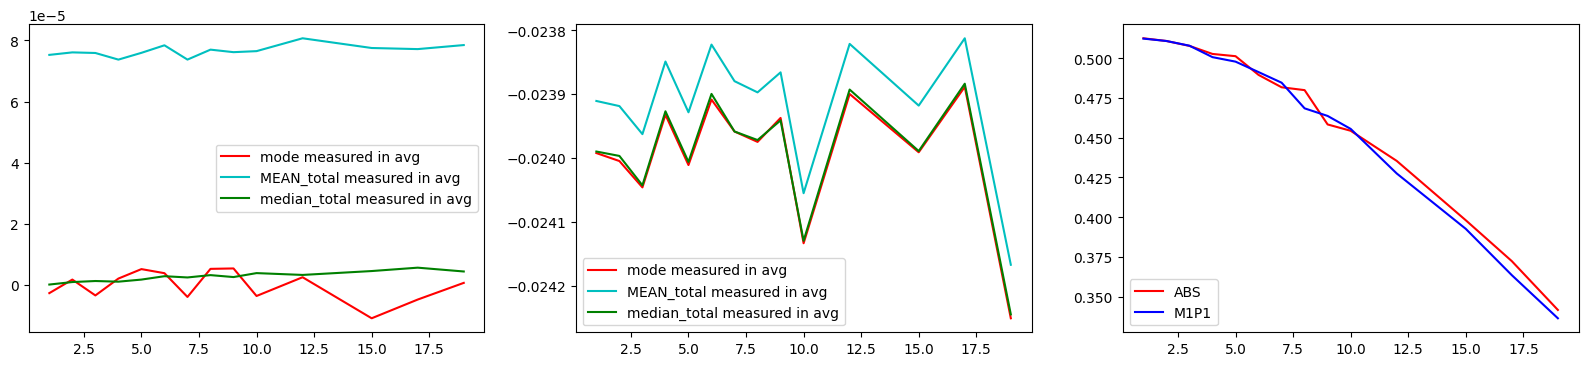

In [29]:
fig, ax = plt.subplots(1,3,figsize=(20,4))

ax[0].plot(std,metrics_hist_corrupted_avgs['mode']['mean'],color='red', label = 'mode'+' measured in avg')
#ax[0].fill_between(std, metrics_hist_corrupted_avgs['mode']['mean'] - metrics_hist_corrupted_avgs['mode']['std'], 
#                       metrics_hist_corrupted_avgs['mode']['mean'] + metrics_hist_corrupted_avgs['mode']['std'], alpha=0.35, color = 'red')
ax[0].plot(std,metrics_spgram_corrupted_avgs['MEAN_total']['mean'],color='c', label = 'MEAN_total'+' measured in avg')
#ax[0].fill_between(std, metrics_spgram_corrupted_avgs['MEAN_total']['mean'] - metrics_spgram_corrupted_avgs['MEAN_total']['std'], 
#                       metrics_spgram_corrupted_avgs['MEAN_total']['mean'] + metrics_spgram_corrupted_avgs['MEAN_total']['std'], alpha=0.35, color = 'c')
ax[0].plot(std,metrics_spgram_corrupted_avgs['median_total']['mean'],color='green', label = 'median_total'+' measured in avg')
#ax[0].fill_between(std, metrics_spgram_corrupted_avgs['median_total']['mean'] - metrics_spgram_corrupted_avgs['median_total']['std'], 
#                       metrics_spgram_corrupted_avgs['median_total']['mean'] + metrics_spgram_corrupted_avgs['median_total']['std'], alpha=0.35, color = 'green')
ax[0].legend(loc='center right')

ax[1].plot(std,metrics_hist_M1P1['mode']['mean'],color='red', label = 'mode'+' measured in avg')
#ax[1].fill_between(std, metrics_hist_M1P1['mode']['mean'] - metrics_hist_M1P1['mode']['std'], 
#                       metrics_hist_M1P1['mode']['mean'] + metrics_hist_M1P1['mode']['std'], alpha=0.35, color = 'red')
ax[1].plot(std,metrics_spgram_M1P1['MEAN_total']['mean'],color='c', label = 'MEAN_total'+' measured in avg')
#ax[1].fill_between(std, metrics_spgram_M1P1['MEAN_total']['mean'] - metrics_spgram_M1P1['MEAN_total']['std'], 
#                       metrics_spgram_M1P1['MEAN_total']['mean'] + metrics_spgram_M1P1['MEAN_total']['std'], alpha=0.35, color = 'c')
ax[1].plot(std,metrics_spgram_M1P1['median_total']['mean'],color='green', label = 'median_total'+' measured in avg')
#ax[1].fill_between(std, metrics_spgram_M1P1['median_total']['mean'] - metrics_spgram_M1P1['median_total']['std'], 
#                       metrics_spgram_M1P1['median_total']['mean'] + metrics_spgram_M1P1['median_total']['std'], alpha=0.35, color = 'green')
ax[1].legend(loc='lower left')

ax[2].plot(std,metrics_hist_corrupted_avgs['skewness']['mean'],color='red', label = 'ABS')
ax[2].plot(std,metrics_hist_M1P1['skewness']['mean'],color='b', label = 'M1P1')
ax[2].legend(loc='lower left')

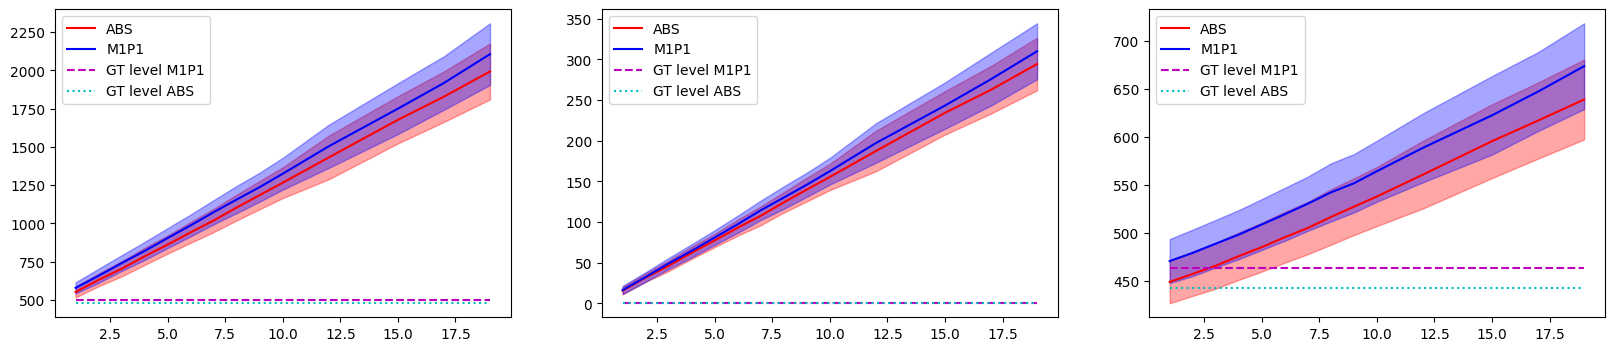

In [46]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
aux_list = ['TV_aniso_total','TV_aniso_late','TV_aniso_main_sig']
for i in range(len(aux_list)): 
    ax[i].plot(std,metrics_spgram_corrupted_avgs[aux_list[i]]['mean'],color='red', label = 'ABS')
    ax[i].plot(std,metrics_spgram_M1P1[aux_list[i]]['mean'],color='b', label = 'M1P1')
    ax[i].hlines(metrics_spgram_gt_M1P1[aux_list[i]]['mean'],std[0],std[-1],color='m',linestyle='dashed',label='GT level M1P1')
    ax[i].hlines(metrics_spgram_gt[aux_list[i]]['mean'],std[0],std[-1],color='c',linestyle='dotted',label='GT level ABS')
    ax[i].fill_between(std, metrics_spgram_corrupted_avgs[aux_list[i]]['mean'] - metrics_spgram_corrupted_avgs[aux_list[i]]['std'], 
                           metrics_spgram_corrupted_avgs[aux_list[i]]['mean'] + metrics_spgram_corrupted_avgs[aux_list[i]]['std'], alpha=0.35, color = 'red')
    ax[i].fill_between(std, metrics_spgram_M1P1[aux_list[i]]['mean'] - metrics_spgram_M1P1[aux_list[i]]['std'], 
                           metrics_spgram_M1P1[aux_list[i]]['mean'] + metrics_spgram_M1P1[aux_list[i]]['std'], alpha=0.35, color = 'blue')
    ax[i].legend(loc='upper left')

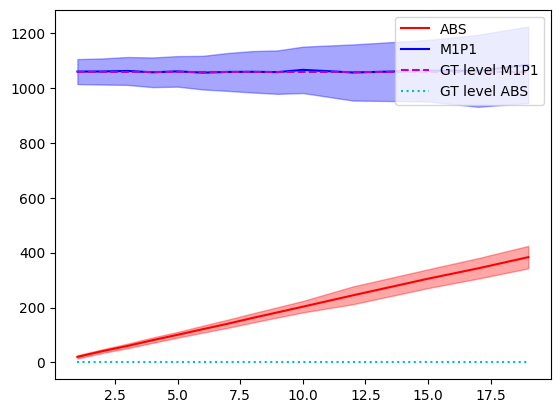

In [62]:
plt.plot(std,metrics_spgram_corrupted_avgs['sum_late']['mean'],color='red', label = 'ABS')
plt.plot(std,metrics_spgram_M1P1['sum_late']['mean'],color='b', label = 'M1P1')
plt.hlines(metrics_spgram_gt_M1P1['sum_late']['mean'],std[0],std[-1],color='m',linestyle='dashed',label='GT level M1P1')
plt.hlines(metrics_spgram_gt['sum_late']['mean'],std[0],std[-1],color='c',linestyle='dotted',label='GT level ABS')
plt.fill_between(std, metrics_spgram_corrupted_avgs['sum_late']['mean'] - metrics_spgram_corrupted_avgs['sum_late']['std'], 
                       metrics_spgram_corrupted_avgs['sum_late']['mean'] + metrics_spgram_corrupted_avgs['sum_late']['std'], alpha=0.35, color = 'red')
plt.fill_between(std, metrics_spgram_M1P1['sum_late']['mean'] - metrics_spgram_M1P1['sum_late']['std'], 
                       metrics_spgram_M1P1['sum_late']['mean'] + metrics_spgram_M1P1['sum_late']['std'], alpha=0.35, color = 'blue')
plt.legend(loc='upper right')